## Predicting HINI and Seasonal Flu Vaccines Recipient 

### Import Modules

In [1]:
import pandas as pd

# Visuallization Libraries
import matplotlib.pyplot as plt
from matplotlib_venn import venn2_unweighted
import seaborn as sns

# clf Selection and Pipeline
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Model
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
# Metrics
from sklearn.metrics import roc_auc_score, roc_curve

### Prepare Data

#### Import 

In [8]:
def wrangle(featurespath, labelspath):
    # Read the features and labels filepath 
    df1 = pd.read_csv(featurespath)
    df2 = pd.read_csv(labelspath)
    assert df1.index.all() == df2.index.all(), "The features index must be same with label index" 
    
    # Merge the two data frame 
    df = df1.merge(df2, on="respondent_id").set_index("respondent_id")
    
    # Drop the employment columns (They contain too many null values and are of random characters)
    mask_employment = ["employment_occupation", "employment_industry", "health_insurance"] 
    

    df.drop(columns=mask_employment, inplace=True)
    
    # Drop columns that can cause leakages
    mask_leakages = ["opinion_h1n1_vacc_effective", "opinion_seas_vacc_effective"]
    df.drop(columns=mask_leakages, inplace=True)
   
    return df

In [9]:
df = wrangle(featurespath="training_set_features.csv",
        labelspath="training_set_labels.csv")

#### Clean and  Explore

##### Exploratory Data Analysis

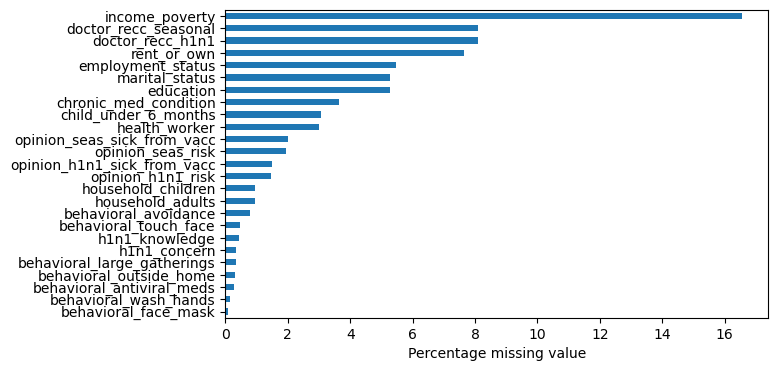

In [10]:
# To plot the columns with null value 
nan_columns = []

# loop through any columns that contains null value
for column in df.columns:
    if df[column].isnull().any():
        nan_columns.append(column)

fig, ax = plt.subplots(figsize=(7, 4))

# Plot the columns that has null values in descending order
(df[nan_columns].isnull().mean() * 100).sort_values().plot(kind="barh", ax=ax)

plt.xlabel("Percentage missing value");

In [11]:
# Check for collinearity
corr = df.select_dtypes("float").corr()
#corr.style.background_gradient(cmap="PuBu")

"""  It has been shown that the data are not correlated with the 
     most correlation to be a little bit above average.
"""

'  It has been shown that the data are not correlated with the \n     most correlation to be a little bit above average.\n'

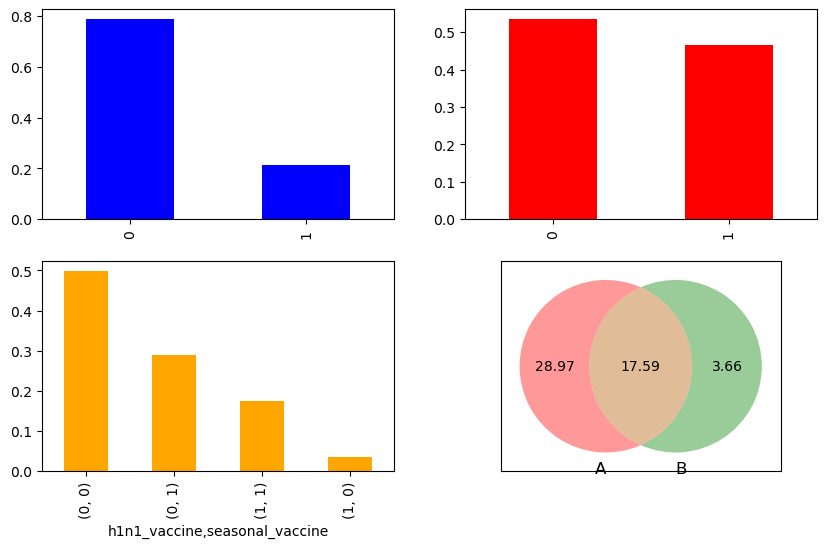

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
# Plot for h1n1_vaccine
df["h1n1_vaccine"].value_counts(normalize=True).plot(kind="bar", ax=ax[0][0], color="b") 
#plt.xlabel("h1n1 & seasonal Vaccine")
#plt.ylabel("Normalized Distribution")
#plt.title("Distribution of both h1n1 and seasonal vaccination");

# Plot for seasonal vaccine
df["seasonal_vaccine"].value_counts(normalize=True).plot(kind="bar", ax=ax[0][1], color="r") 
#plt.xlabel("h1n1 & seasonal Vaccine")
#plt.ylabel("Normalized Distribution")

# Plot for both h1n1 and seasonal vaccine
df[["h1n1_vaccine",  "seasonal_vaccine"]].value_counts(normalize=True).plot(kind="bar", ax=ax[1][0], color="orange") 
#plt.xlabel("h1n1 & seasonal Vaccine")
#plt.ylabel("Normalized Distribution")

# Venn-diagram for h1n1 and seasonal vaccine
element = round(df[["h1n1_vaccine", "seasonal_vaccine"]].value_counts(normalize=True)*100, 2).to_list()
venn2_unweighted(ax=ax[1][1], subsets=(element[1], element[3], element[2], element[0]))
plt.gca().set_facecolor('white')
plt.gca().set_axis_on()
plt.show();

##### Explore attitudes towarads vaccine 


In [13]:
# Columns that contains recipient attitudes towards vaccine 
columns1 = [items for items in df.columns if "h1n1" in items]
columns2 = [items for items in df.columns if "seas" in items]
df_h1n1 = df[columns1]
df_seas = df[columns2]

In [14]:
# To concatenate the columns that contains attribute of recipient to vaccine
df_att = pd.concat([df_h1n1, df_seas], axis=1)#.set_index("respondent_id")

att_cols = [cols for cols in df_att.columns]

print("df_att shape:", df_att.shape)
df_att.head()

df_att shape: (26707, 10)


,h1n1_concern,h1n1_knowledge,doctor_recc_h1n1,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,h1n1_vaccine,doctor_recc_seasonal,opinion_seas_risk,opinion_seas_sick_from_vacc,seasonal_vaccine
respondent_id,,,,,,,,,,
0,1.0,0.0,0.0,1.0,2.0,0,0.0,1.0,2.0,0
1,3.0,2.0,0.0,4.0,4.0,0,0.0,2.0,4.0,1
2,1.0,1.0,NaN,1.0,1.0,0,NaN,1.0,2.0,0
3,1.0,1.0,0.0,3.0,5.0,0,1.0,4.0,1.0,1
4,2.0,1.0,0.0,3.0,2.0,0,0.0,1.0,4.0,0


In [15]:
corr = df_att.drop(columns=["h1n1_vaccine", "seasonal_vaccine"]).corr()
#corr.style.background_gradient(cmap="PuBu")

"""  It has been shown that the data are not correlated with the 
     most correlation to be a little bit above average.
"""

'  It has been shown that the data are not correlated with the \n     most correlation to be a little bit above average.\n'

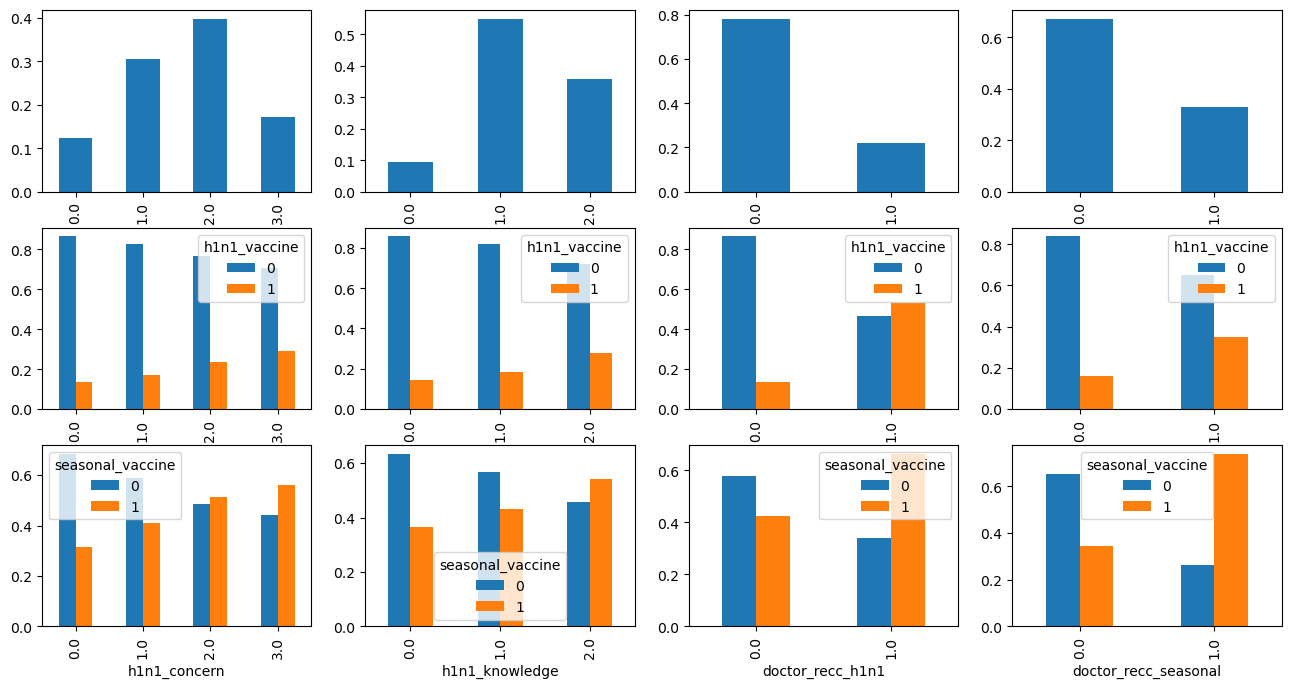

In [16]:
fig, ax = plt.subplots(3, 4, figsize=(16, 8))
# Plot for h1n1_concern
df_att["h1n1_concern"].value_counts(normalize=True).sort_index().plot(kind="bar", ax=ax[0][0])
df_att.groupby("h1n1_concern")["h1n1_vaccine"].value_counts(normalize=True).unstack().sort_index().plot(kind="bar", ax=ax[1][0])
df_att.groupby("h1n1_concern")["seasonal_vaccine"].value_counts(normalize=True).unstack().sort_index().plot(kind="bar", ax=ax[2][0])


# Plot for h1n1 knowledge
df_att["h1n1_knowledge"].value_counts(normalize=True).sort_index().plot(kind="bar", ax=ax[0][1]) 
df_att.groupby("h1n1_knowledge")["h1n1_vaccine"].value_counts(normalize=True).unstack().sort_index().plot(kind="bar", ax=ax[1][1])
df_att.groupby("h1n1_knowledge")["seasonal_vaccine"].value_counts(normalize=True).unstack().sort_index().plot(kind="bar", ax=ax[2][1])

# Plot for both h1n1 and seasonal vaccine
df_att["doctor_recc_h1n1"].value_counts(normalize=True).sort_index().plot(kind="bar", ax=ax[0][2]) 
df_att.groupby("doctor_recc_h1n1")["h1n1_vaccine"].value_counts(normalize=True).unstack().sort_index().plot(kind="bar", ax=ax[1][2])
df_att.groupby("doctor_recc_h1n1")["seasonal_vaccine"].value_counts(normalize=True).unstack().sort_index().plot(kind="bar", ax=ax[2][2])


# Plot for both h1n1 and seasonal vaccine
df_att["doctor_recc_seasonal"].value_counts(normalize=True).sort_index().plot(kind="bar", ax=ax[0][3]) 
df_att.groupby("doctor_recc_seasonal")["h1n1_vaccine"].value_counts(normalize=True).unstack().sort_index().plot(kind="bar", ax=ax[1][3])
df_att.groupby("doctor_recc_seasonal")["seasonal_vaccine"].value_counts(normalize=True).unstack().sort_index().plot(kind="bar", ax=ax[2][3])
plt.show();

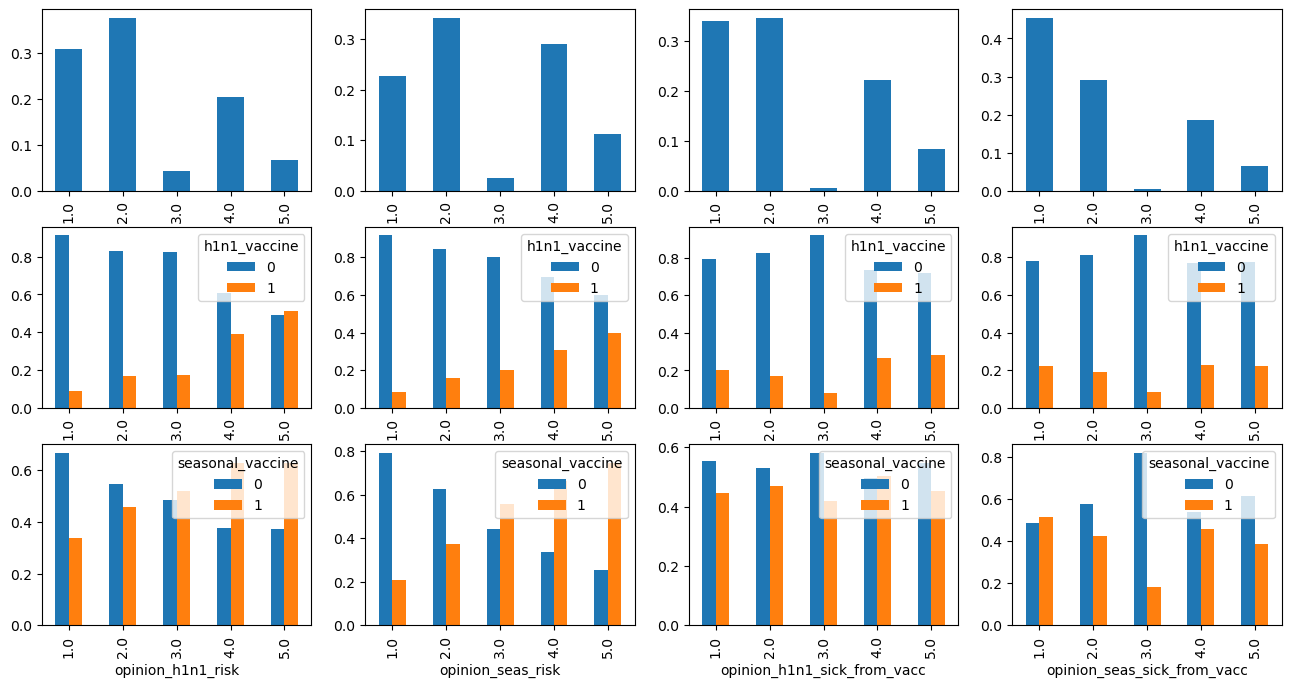

In [17]:
fig, ax = plt.subplots(3, 4, figsize=(16, 8))
# Plot for h1n1_concern
df_att["opinion_h1n1_risk"].value_counts(normalize=True).sort_index().plot(kind="bar", ax=ax[0][0])
df_att.groupby("opinion_h1n1_risk")["h1n1_vaccine"].value_counts(normalize=True).unstack().sort_index().plot(kind="bar", ax=ax[1][0])
df_att.groupby("opinion_h1n1_risk")["seasonal_vaccine"].value_counts(normalize=True).unstack().sort_index().plot(kind="bar", ax=ax[2][0])


# Plot for h1n1 knowledge
df_att["opinion_seas_risk"].value_counts(normalize=True).sort_index().plot(kind="bar", ax=ax[0][1]) 
df_att.groupby("opinion_seas_risk")["h1n1_vaccine"].value_counts(normalize=True).unstack().sort_index().plot(kind="bar", ax=ax[1][1])
df_att.groupby("opinion_seas_risk")["seasonal_vaccine"].value_counts(normalize=True).unstack().sort_index().plot(kind="bar", ax=ax[2][1])

# Plot for both h1n1 and seasonal vaccine
df_att["opinion_h1n1_sick_from_vacc"].value_counts(normalize=True).sort_index().plot(kind="bar", ax=ax[0][2]) 
df_att.groupby("opinion_h1n1_sick_from_vacc")["h1n1_vaccine"].value_counts(normalize=True).unstack().sort_index().plot(kind="bar", ax=ax[1][2])
df_att.groupby("opinion_h1n1_sick_from_vacc")["seasonal_vaccine"].value_counts(normalize=True).unstack().sort_index().plot(kind="bar", ax=ax[2][2])


# Plot for both h1n1 and seasonal vaccine
df_att["opinion_seas_sick_from_vacc"].value_counts(normalize=True).sort_index().plot(kind="bar", ax=ax[0][3]) 
df_att.groupby("opinion_seas_sick_from_vacc")["h1n1_vaccine"].value_counts(normalize=True).unstack().sort_index().plot(kind="bar", ax=ax[1][3])
df_att.groupby("opinion_seas_sick_from_vacc")["seasonal_vaccine"].value_counts(normalize=True).unstack().sort_index().plot(kind="bar", ax=ax[2][3])
plt.show();

##### Explore Demographics 

In [18]:
dem_cols = ["age_group", "education", "sex", "census_msa"]

In [19]:
# Columns that contains demographics data of recipients
demo_col = ['age_group', 'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', "h1n1_vaccine", "seasonal_vaccine"
       ]

df_demo = df[demo_col + ["h1n1_vaccine", "seasonal_vaccine"]]
print(df_demo.shape)
df_demo.head()

(26707, 16)


,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,h1n1_vaccine,seasonal_vaccine,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,
0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,0,0,0,0
1,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,0,1,0,1
2,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,0,0,0,0
3,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,0,1,0,1
4,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,0,0,0,0


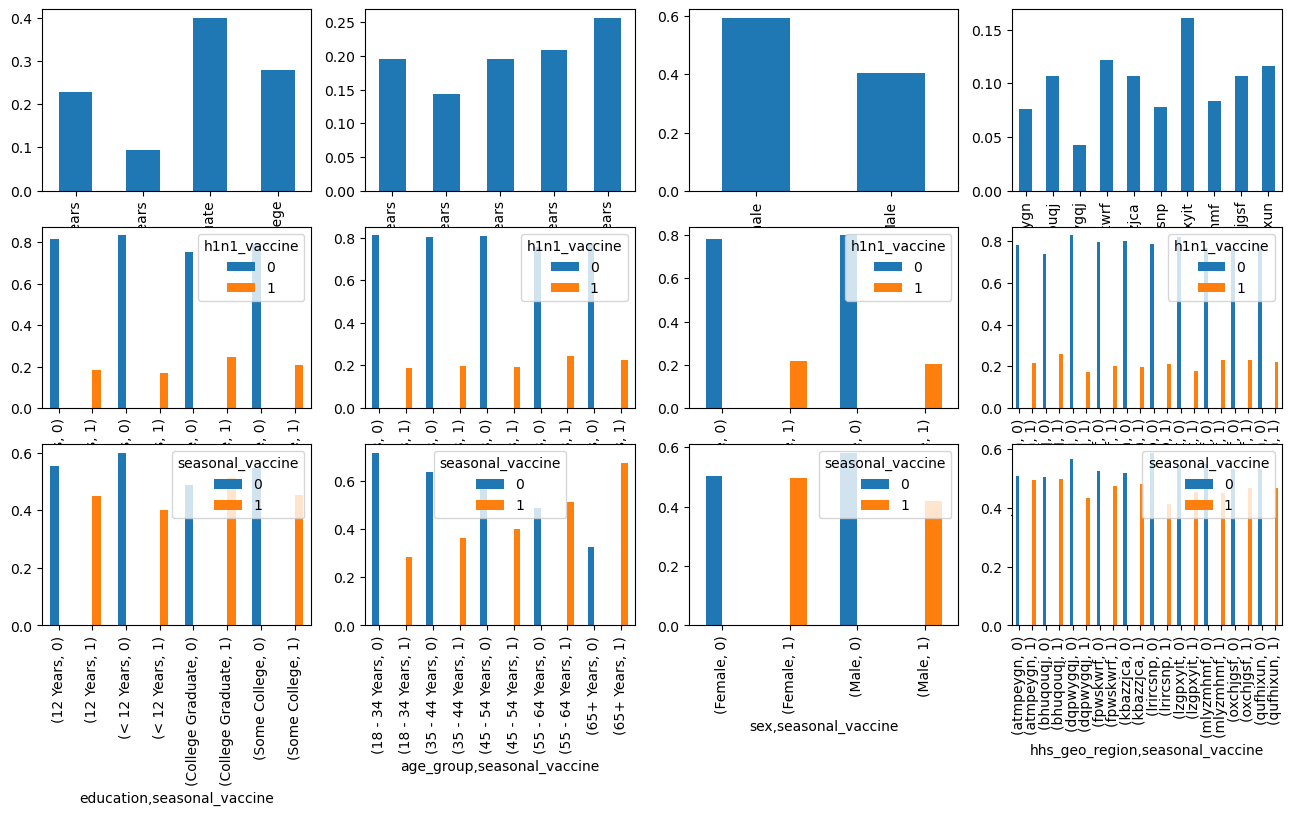

In [20]:
fig, ax = plt.subplots(3, 4, figsize=(16, 8))
# Plot for h1n1_concern
df_demo["education"].value_counts(normalize=True).sort_index().plot(kind="bar", ax=ax[0][0])
df_demo.groupby("education")["h1n1_vaccine"].value_counts(normalize=True).unstack().sort_index().plot(kind="bar", ax=ax[1][0])
df_demo.groupby("education")["seasonal_vaccine"].value_counts(normalize=True).unstack().sort_index().plot(kind="bar", ax=ax[2][0])


# Plot for h1n1 knowledge
df_demo["age_group"].value_counts(normalize=True).sort_index().plot(kind="bar", ax=ax[0][1]) 
df_demo.groupby("age_group")["h1n1_vaccine"].value_counts(normalize=True).unstack().sort_index().plot(kind="bar", ax=ax[1][1])
df_demo.groupby("age_group")["seasonal_vaccine"].value_counts(normalize=True).unstack().sort_index().plot(kind="bar", ax=ax[2][1])

# Plot for both h1n1 and seasonal vaccine
df_demo["sex"].value_counts(normalize=True).sort_index().plot(kind="bar", ax=ax[0][2]) 
df_demo.groupby("sex")["h1n1_vaccine"].value_counts(normalize=True).unstack().sort_index().plot(kind="bar", ax=ax[1][2])
df_demo.groupby("sex")["seasonal_vaccine"].value_counts(normalize=True).unstack().sort_index().plot(kind="bar", ax=ax[2][2])


# Plot for both h1n1 and seasonal vaccine
df_demo["hhs_geo_region"].value_counts(normalize=True).sort_index().plot(kind="bar", ax=ax[0][3]) 
df_demo.groupby("hhs_geo_region")["h1n1_vaccine"].value_counts(normalize=True).unstack().sort_index().plot(kind="bar", ax=ax[1][3])
df_demo.groupby("hhs_geo_region")["seasonal_vaccine"].value_counts(normalize=True).unstack().sort_index().plot(kind="bar", ax=ax[2][3])
plt.show();

##### Explore Behavioral features

In [21]:
df_att_col = df_att.columns
df_demo_col = df_demo.columns

beh_cols = [x for x in df.columns if x not in (df_att_col.to_list() + df_demo_col.to_list())]

df_beh = df[beh_cols + ["h1n1_vaccine", "seasonal_vaccine"]]

In [22]:
# Columns with significantly less disproportionate labels
["behavioral_antiviral_meds", "behavioral_face_mask", "child_under_6_months", "health_worker"]

['behavioral_antiviral_meds',
 'behavioral_face_mask',
 'child_under_6_months',
 'health_worker']

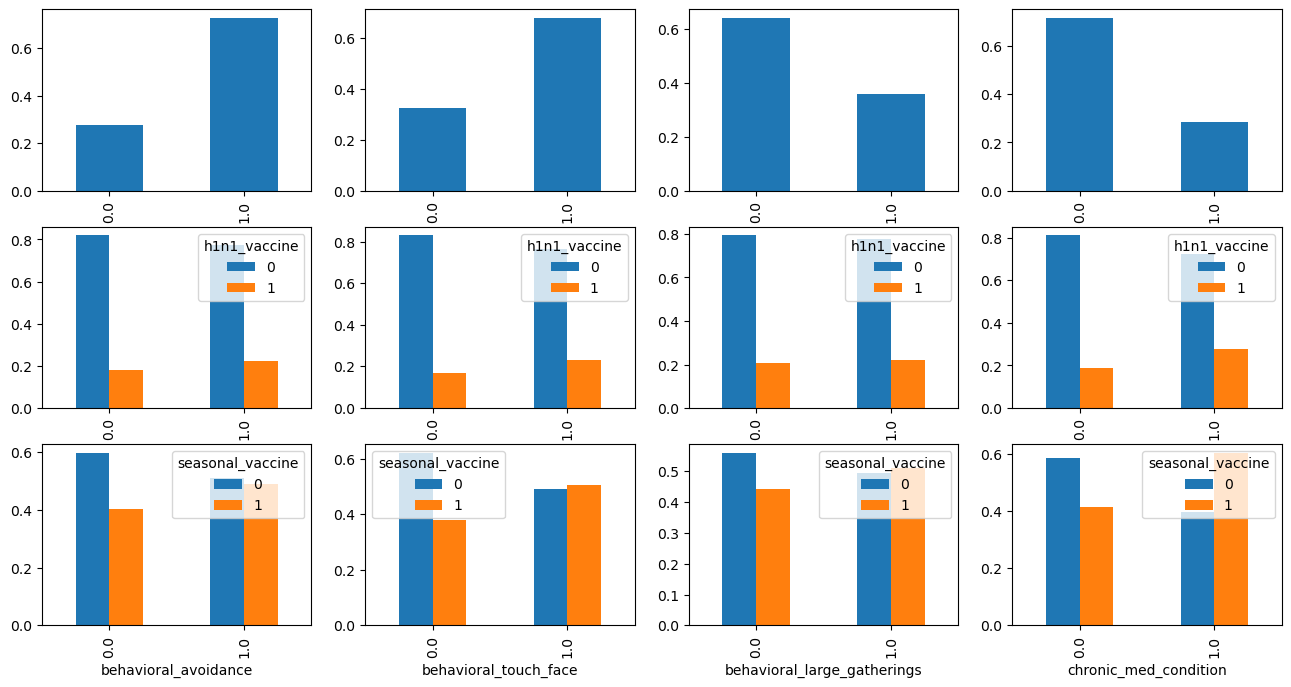

In [23]:
fig, ax = plt.subplots(3, 4, figsize=(16, 8))
# Plot for h1n1_concern
df_beh["behavioral_avoidance"].value_counts(normalize=True).sort_index().plot(kind="bar", ax=ax[0][0])
df_beh.groupby("behavioral_avoidance")["h1n1_vaccine"].value_counts(normalize=True).unstack().sort_index().plot(kind="bar", ax=ax[1][0])
df_beh.groupby("behavioral_avoidance")["seasonal_vaccine"].value_counts(normalize=True).unstack().sort_index().plot(kind="bar", ax=ax[2][0])


# Plot for h1n1 knowledge
df_beh["behavioral_touch_face"].value_counts(normalize=True).sort_index().plot(kind="bar", ax=ax[0][1]) 
df_beh.groupby("behavioral_touch_face")["h1n1_vaccine"].value_counts(normalize=True).unstack().sort_index().plot(kind="bar", ax=ax[1][1])
df_beh.groupby("behavioral_touch_face")["seasonal_vaccine"].value_counts(normalize=True).unstack().sort_index().plot(kind="bar", ax=ax[2][1])

# Plot for both h1n1 and seasonal vaccine
df_beh["behavioral_large_gatherings"].value_counts(normalize=True).sort_index().plot(kind="bar", ax=ax[0][2]) 
df_beh.groupby("behavioral_large_gatherings")["h1n1_vaccine"].value_counts(normalize=True).unstack().sort_index().plot(kind="bar", ax=ax[1][2])
df_beh.groupby("behavioral_large_gatherings")["seasonal_vaccine"].value_counts(normalize=True).unstack().sort_index().plot(kind="bar", ax=ax[2][2])


# Plot for both h1n1 and seasonal vaccine
df_beh["chronic_med_condition"].value_counts(normalize=True).sort_index().plot(kind="bar", ax=ax[0][3]) 
df_beh.groupby("chronic_med_condition")["h1n1_vaccine"].value_counts(normalize=True).unstack().sort_index().plot(kind="bar", ax=ax[1][3])
df_beh.groupby("chronic_med_condition")["seasonal_vaccine"].value_counts(normalize=True).unstack().sort_index().plot(kind="bar", ax=ax[2][3])
plt.show();

#### Split

In [24]:
demo_cols = ["education", "age_group", "sex", "census_msa"]

beh_cols = ["behavioral_avoidance", "behavioral_touch_face", "behavioral_large_gatherings", "chronic_med_condition"]

column = [demo_cols + att_cols + beh_cols]

In [25]:
sub_df = df[column[0]]
#sub_df = sub_df.select_dtypes("float")
sub_df.head()

,education,age_group,sex,census_msa,h1n1_concern,h1n1_knowledge,doctor_recc_h1n1,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,h1n1_vaccine,doctor_recc_seasonal,opinion_seas_risk,opinion_seas_sick_from_vacc,seasonal_vaccine,behavioral_avoidance,behavioral_touch_face,behavioral_large_gatherings,chronic_med_condition
respondent_id,,,,,,,,,,,,,,,,,,
0,< 12 Years,55 - 64 Years,Female,Non-MSA,1.0,0.0,0.0,1.0,2.0,0,0.0,1.0,2.0,0,0.0,1.0,0.0,0.0
1,12 Years,35 - 44 Years,Male,"MSA, Not Principle City",3.0,2.0,0.0,4.0,4.0,0,0.0,2.0,4.0,1,1.0,1.0,0.0,0.0
2,College Graduate,18 - 34 Years,Male,"MSA, Not Principle City",1.0,1.0,NaN,1.0,1.0,0,NaN,1.0,2.0,0,1.0,0.0,0.0,1.0
3,12 Years,65+ Years,Female,"MSA, Principle City",1.0,1.0,0.0,3.0,5.0,0,1.0,4.0,1.0,1,1.0,0.0,1.0,1.0
4,Some College,45 - 54 Years,Female,"MSA, Not Principle City",2.0,1.0,0.0,3.0,2.0,0,0.0,1.0,4.0,0,1.0,1.0,1.0,0.0


In [26]:
target = ["h1n1_vaccine", "seasonal_vaccine"] 
X = sub_df.drop(columns=target)
y = sub_df[target]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X.select_dtypes("float"), y, test_size=0.2, random_state=42)
assert X_train.shape[0] == (int(0.8 * len(df_att)))

### Build Model

#### Baseline

In [28]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Accuracy Baseline:", round(acc_baseline, 4))

Accuracy Baseline: 0.4966


#### Iterate

In [32]:
model = make_pipeline(SimpleImputer(strategy='most_frequent'),
                      #OneHotEncoder(use_cat_names=True),
                      StandardScaler(),
                      MultiOutputClassifier(estimator=LogisticRegression(random_state=42))
)

In [33]:
model.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('standardscaler', StandardScaler()),
                ('multioutputclassifier',
                 MultiOutputClassifier(estimator=LogisticRegression(random_state=42)))])

#### Evaluate

In [35]:
y_train_proba = model.predict_proba(X_train)

y_train_pred = pd.DataFrame(
    {
        "h1n1_vaccine": y_train_proba[0][:, 1],
        "seasonal_vaccine": y_train_proba[1][:, 1],
    },
    index = y_train.index
)

In [36]:
y_predict_proba = model.predict_proba(X_test)

y_test_pred = pd.DataFrame(
    {
        "h1n1_vaccine": y_predict_proba[0][:, 1],
        "seasonal_vaccine": y_predict_proba[1][:, 1],
    },
    index = y_test.index
)
# y_pred.head()

In [37]:
print("baseline accuracy:", round(acc_baseline, 4))
print("training accuracy:", round(roc_auc_score(y_train, y_train_pred), 4))
print("testing accuracy:", round(roc_auc_score(y_test, y_test_pred), 4))

baseline accuracy: 0.4966
training accuracy: 0.7976
testing accuracy: 0.8015


In [ ]:
# Build Classifier pipeline that contains all transformers and estimators

clf_dt = make_pipeline(
    StandardScaler(), KNNImputer(),
    MultiOutputClassifier(estimator=DecisionTreeClassifier(random_state=42))
)

In [ ]:
# Build parameter for GridsearchCV

params_dt = {
    "knnimputer__n_neighbors" : range(1, 6, 1),
    "multioutputclassifier__estimator__max_depth" : range(10, 50, 10),
    "multioutputclassifier__estimator__min_samples_split" : range(1, 3, 1),
    "multioutputclassifier__estimator__min_samples_leaf" : range(1, 3, 1),
    "multioutputclassifier__estimator__max_features" : ['sqrt']
}

model = GridSearchCV(estimator=clf_dt, param_grid=params_dt, n_jobs=-1, cv=5, verbose=1)
model.fit(X_train, y_train)

In [ ]:
print("Model Best Score:", model.best_score_)
print("Model Best Parameter:", model.best_params_)

In [ ]:
y_train_proba = model.predict_proba(X_train)

y_train_pred = pd.DataFrame(
    {
        "h1n1_vaccine": y_train_proba[0][:, 1],
        "seasonal_vaccine": y_train_proba[1][:, 1],
    },
    index = y_train.index
)

In [ ]:
y_predict_proba = model.predict_proba(X_test)

y_test_pred = pd.DataFrame(
    {
        "h1n1_vaccine": y_predict_proba[0][:, 1],
        "seasonal_vaccine": y_predict_proba[1][:, 1],
    },
    index = y_test.index
)
# y_pred.head()

In [ ]:
print("baseline accuracy:", round(acc_baseline, 4))
print("training accuracy:", round(roc_auc_score(y_train, y_train_pred), 4))
print("testing accuracy:", round(roc_auc_score(y_test, y_test_pred), 4))

### Communicate

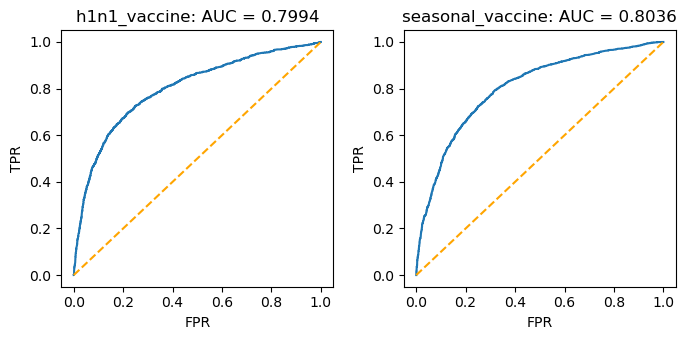

In [38]:
# Plot the roc_auc curve 

def plot_roc(y_true, y_pred, title, ax):
    
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    
    ax.plot(fpr, tpr)
    
    ax.plot([0, 1], [0, 1], color='orange', linestyle='--')
    
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(f"{title}: AUC = {round(roc_auc_score(y_true, y_pred), 4)}")
    
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

plot_roc(
    y_test['h1n1_vaccine'], y_test_pred['h1n1_vaccine'], 
    'h1n1_vaccine', ax=ax[0]
)

plot_roc(
    y_test['seasonal_vaccine'], y_test_pred['seasonal_vaccine'], 
    'seasonal_vaccine', ax=ax[1]
)

fig.tight_layout()

#### Submission

In [39]:
# Read submission format into dataframe 
sub_format = pd.read_csv("submission_format.csv").set_index("respondent_id")

# Extract the index from df_att
index = (X_train.reset_index()
         .columns.to_list())#.drop(["h1n1_vaccine", "seasonal_vaccine"])
         #.to_list())

# Read the testing data into DataFrame using only data from df_att
test_X_data = (pd.read_csv("test_set_features.csv", usecols=index, index_col="respondent_id")
         .reindex(columns=X_train.columns)) # Shuffle the new column so it follows that of df_att
         #.drop(columns=["h1n1_vaccine", "seasonal_vaccine"])) # Drop the target columns from the DataFrame

test_y_data = (pd.read_csv("test_set_features.csv", usecols=index, index_col="respondent_id")
         .reindex(columns=y_train.columns)) # Shuffle the new column so it follows that of df_att
         #.drop(columns=["h1n1_vaccine", "seasonal_vaccine"])) # Drop the target columns from the DataFrame

assert sub_format.index.all() == test_X_data.index.all()

In [42]:
# Predict testing data
test_predict = model.predict_proba(test_X_data)
# Create dataframe with testing data
test_pred = pd.DataFrame(
    {
        "h1n1_vaccine": test_predict[0][:, 1],
        "seasonal_vaccine": test_predict[1][:, 1],
    },
    index = test_X_data.index
)
test_pred.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.069820,0.272048
26708,0.061804,0.167379
26709,0.246887,0.483658
26710,0.479212,0.811529
26711,0.109703,0.550712


In [43]:
test_X_data.columns

Index(['h1n1_concern', 'h1n1_knowledge', 'doctor_recc_h1n1',
       'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc',
       'doctor_recc_seasonal', 'opinion_seas_risk',
       'opinion_seas_sick_from_vacc', 'behavioral_avoidance',
       'behavioral_touch_face', 'behavioral_large_gatherings',
       'chronic_med_condition'],
      dtype='object')

In [44]:
test_pred.to_csv("my_submission_lr_tuned.csv", index=True)